# Synthetic Cohort Generation

Generates longitudinal lung cancer patient cohorts with TNM staging and RECIST response tracking for research and AI benchmarking.

## 0) Imports

In [1]:
# Add synthrad module directory to path
from pathlib import Path
import sys
import shutil
import json
import os
from collections import defaultdict

# Generic way to find the module directory (works in notebooks)
MODULE_DIR = Path(os.getcwd()).parent / "src" / "synthrad"
assert (MODULE_DIR / "generator.py").exists(), f"Can't find generator.py in {MODULE_DIR}"
sys.path.insert(0, str(MODULE_DIR))

# Import and reload modules
from synthrad import generator as gen, lexicons, schema
import importlib
importlib.reload(gen)
importlib.reload(lexicons) 
importlib.reload(schema)

print("Loaded modules from:", MODULE_DIR)

Loaded modules from: /Users/eri/synthetic_reports/src/synthrad


## 1) Cohort Parameters

In [2]:
# ---- cohort knobs ----
N_PATIENTS            = 8          # number of patients to synthesize
SEED                  = 42         # deterministic
STUDIES_PER_PATIENT   = 5          # max studies per patient (can range between 2–10)
FORCE_LOBE            = None       # choose from: None, "RUL","RML","RLL","LUL","LLL"

# Stage distribution (I/II/III/IV) — will be normalized by your parser
STAGE_DIST_STR        = "I:0.25,II:0.25,III:0.30,IV:0.20"

# Response distribution for follow-ups — normalized internally
RESPONSE_DIST_STR     = "CR:0.1,PR:0.3,SD:0.4,PD:0.2"

# Output directory (feel free to change)
OUT_DIR               = Path("./out_synthrad")
if OUT_DIR.exists():
    print("Cleaning existing output dir…")
    shutil.rmtree(OUT_DIR)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Config OK")

rng = gen.random.Random(SEED)
stage_dist     = gen.parse_stage_dist(STAGE_DIST_STR)
response_dist  = gen.parse_response_dist(RESPONSE_DIST_STR)

Cleaning existing output dir…
Config OK


## 2) Generate the Cohort (multi-visit timelines)

In [3]:
from synthrad.ontology_config_generator import OntologyConfigGenerator

ontology_generator = OntologyConfigGenerator(use_radlex=True)

all_cases = []
all_dates = []

for i in range(N_PATIENTS):
    patient_id = f"P{i:04d}"
    try:
        cases, study_dates = gen.generate_patient_timeline(
            patient_id=patient_id,
            seed=rng.randint(0, 10_000_000),
            stage_dist=stage_dist,
            lobe=FORCE_LOBE,
            max_studies=STUDIES_PER_PATIENT,
            response_dist=response_dist
        )
        
        # Write each study (ontology config only)
        for i, c in enumerate(cases):
            study_date = study_dates[i] if i < len(study_dates) else None
            gen.write_case(c, str(OUT_DIR), c.meta.accession_number, use_radlex=True, ontology_generator=ontology_generator, study_date=study_date, ontology_only=True)
        
        all_cases.extend(cases)
        all_dates.extend(study_dates)
    except ZeroDivisionError:
        print(f"Warning: Skipping patient {patient_id} due to zero SLD in baseline scan")
        continue

print(f"Created {len(all_cases)} studies across {len(set(c.meta.patient_id for c in all_cases))} patients → {OUT_DIR.resolve()}")
print(f"Generated ontology-only JSON files in patient directories")


Created 38 studies across 8 patients → /Users/eri/synthetic_reports/notebooks/out_synthrad
Generated ontology-only JSON files in patient directories


In [4]:
# Generate JSONL from ontology files
try:
    jsonl_data = gen.ontology_to_jsonl(str(OUT_DIR))
    jsonl_path = OUT_DIR / "cohort.jsonl"
    
    # Write compact JSONL
    with jsonl_path.open("w", encoding="utf-8") as f:
        for rec in jsonl_data:
            f.write(json.dumps(rec, separators=(",", ":")) + "\n")
    
    print(f"Generated JSONL: {jsonl_path.resolve()}")
    print(f"Total JSONL records: {len(jsonl_data)}")
    
    # Show summary statistics
    patients = len(set(r['patient_id'] for r in jsonl_data))
    studies = len(jsonl_data)
    print(f"JSONL Summary: {studies} studies across {patients} patients")
    
    # Response distribution
    responses = [r['overall_response'] for r in jsonl_data if r['overall_response'] != 'Baseline']
    if responses:
        from collections import Counter
        response_counts = Counter(responses)
        print(f"Response distribution:")
        for response, count in response_counts.most_common():
            print(f"  {response}: {count}")
    
    # Show sample record
    print(f"\nSample JSONL record:")
    print(json.dumps(jsonl_data[0], indent=2, sort_keys=True))
    
except Exception as e:
    print(f"Warning: Failed to generate JSONL from ontology files: {e}")

Generated JSONL: /Users/eri/synthetic_reports/notebooks/out_synthrad/cohort.jsonl
Total JSONL records: 38
JSONL Summary: 38 studies across 8 patients
Response distribution:
  Partial response: 10
  Progressive disease: 9
  Complete response: 6
  Stable disease: 5

Sample JSONL record:
{
  "baseline_sld_mm": 32,
  "current_sld_mm": 32,
  "lesions": [
    {
      "baseline_mm": 14,
      "follow_mm": null,
      "kind": "primary",
      "lesion_id": "L-P0000-PRIMARY-001",
      "location": "right middle lobe of lung",
      "margin": "smooth",
      "necrosis": false,
      "organ": "lung",
      "rule": "longest",
      "size_mm_current": 14,
      "suspicious": true,
      "target": true
    },
    {
      "baseline_mm": 9,
      "follow_mm": null,
      "kind": "node",
      "lesion_id": "L-P0000-LN-4L-002",
      "location": "left lower paratracheal lymph node (4L)",
      "margin": "smooth",
      "necrosis": false,
      "organ": "lymph_node",
      "reason": "too_small",
      "ru

## 3) (Optional) Timeline Plot per Patient
- Top panel: Target lesion trajectories (each line = one lesion). You can see shrinkage or growth over time.
- Middle panel: SLD curve, with vertical shading when the stage group changes (e.g. IV bands when new mets appear).
- Bottom panel: TNM breakdown (T, N, M codes under each timepoint) so you can confirm that stage jumps are driven by nodal/metastatic progression, not just tumor size.

/Users/eri/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Plotting patient: P0000


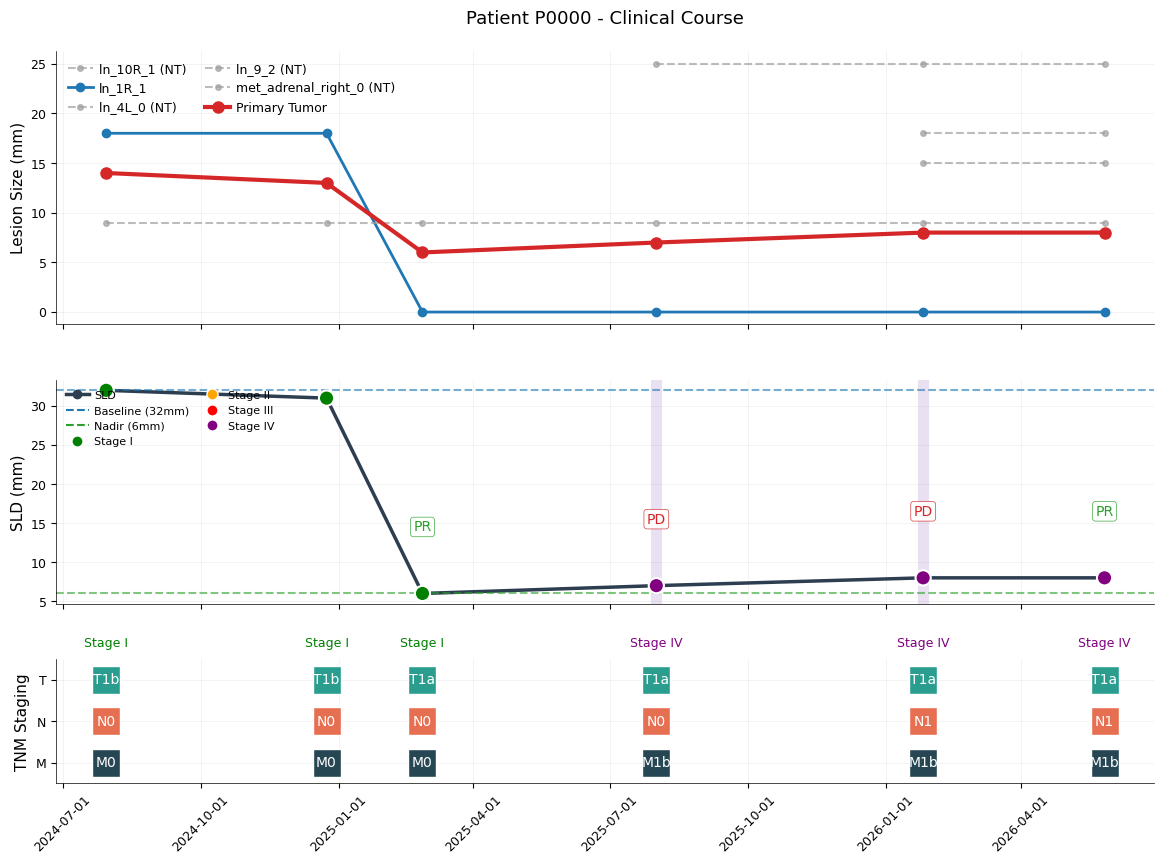


CLINICAL SUMMARY - Patient P0000
Studies: 6 | Baseline SLD: 32mm | Nadir: 6mm | Latest: 8mm
Best Response: PR | Current Stage: IV
Key Events: PR at 2025-02-26 (SLD: 6mm) | PD at 2025-08-01 (SLD: 7mm) | PD at 2026-01-26 (SLD: 8mm) | PR at 2026-05-27 (SLD: 8mm)


In [ ]:
# Import the consolidated clinical visualization module
from clinical_visualization import plot_patient_course

# Prepare data structures
per_patient = defaultdict(list)
for case, dt in zip(all_cases, all_dates):
    per_patient[case.meta.patient_id].append((dt, case))

# Convert cases to JSONL format
jsonl_records = gen.case_to_recist_jsonl(all_cases, all_dates)

# Get first patient ID and plot their course
pid = sorted(per_patient.keys())[0]
print(f"Plotting patient: {pid}")

# Plot using the consolidated clinical function
plot_patient_course(pid, per_patient, jsonl_records)

In [ ]:
# Optional: Plot all patients with clinical visualization (uncomment to run)
# plot_all_patients(per_patient, jsonl_records, max_patients=3)

# Alternative: Plot with treatment timeline (uncomment to run)
# from clinical_visualization import create_example_treatment_dates
# treatment_dates = create_example_treatment_dates()
# plot_with_treatment(pid, per_patient, jsonl_records, treatment_dates)
